# Qiskitを用いた量子計算

v1.0になってキャッチアップが辛いが[Qiskit 1.0チートシート](https://qiita.com/notori48/items/da4e2c298c3cd804867c)を参考に実装してみる。

In [1]:
#必要に応じて...
#!pip install qiskit
#!pip install pylatexenc # for circuit drawing
import numpy as np
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

class PairingHamiltonian:
    def __init__(self, Norb, Nocc, gval, delta_eps=1.0):
        self.Norb = Norb
        self.Nocc = Nocc
        self.delta_eps = delta_eps
        self.gval = gval
        self.basis = self.make_basis()
        self.epsilon = self.eval_epsilon()
        self.Hmat = self.eval_Hmat()

    def make_basis(self):
        self.basis = []
        for occ in combinations(range(self.Norb), self.Nocc):
            self.basis.append(occ)

        return self.basis
    
    def eval_epsilon(self):
        self.epsilon = [ 2 * i * self.delta_eps for i in range(self.Norb) ]
        return self.epsilon
    
    def eval_Hmat(self):
        dim = len(self.basis)
        self.Hmat = np.zeros((dim, dim))
        for bra_idx, bra in enumerate(self.basis):
            for ket_idx, ket in enumerate(self.basis):
                # Hamming distance
                diff = [ i for i in bra if i not in ket ]
                same = [ i for i in bra if i in ket ]
                # for SPE term
                if bra_idx == ket_idx:
                    self.Hmat[bra_idx, ket_idx] += np.sum( [self.epsilon[i] for i in same])
                    self.Hmat[bra_idx, ket_idx] += - self.gval * len(same) 
                # for pairing term
                if len(diff) == 1:
                    self.Hmat[bra_idx, ket_idx] = - self.gval

        return self.Hmat

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

def cG1(circ, c_qubit, i, j, theta):
    theta_4 = theta / 4 
    circ.cx(i,j)
    circ.ry(theta_4, i)
    circ.cx(j,i)
    circ.ry(-theta_4, i)
    circ.cx(c_qubit, i)
    circ.ry(theta_4, i)
    circ.cx(j,i)
    circ.ry(-theta_4, i)
    circ.cx(c_qubit, i)
    circ.cx(i,j)

def G(circ, i, j, theta):
    theta_2 = theta / 2 
    circ.cx(i,j)
    circ.ry(theta_2, i)
    circ.cx(j,i)
    circ.ry(-theta_2, i)
    circ.cx(j,i)
    circ.cx(i,j)  

params_exact = np.array([-0.48104276, -1.03976498, -0.98963981, -1.18481738, -0.54832984])

Norb = 4
Nocc = 2
gval = 0.33  

Hamil = PairingHamiltonian(Norb, Nocc, gval)
evals, evecs = np.linalg.eigh(Hamil.Hmat)
evals = np.linalg.eigvalsh(Hamil.Hmat)
Egs_exact = evals[0]
E_HF = Hamil.Hmat[0,0]

print("basis:", Hamil.basis)
print([tuple_to_bitstring(tup, Norb) for tup in Hamil.basis])
print("eps: ", Hamil.epsilon)
print("Hmat: ", Hamil.Hmat)
print("evals: ", evals)
print("Egs_exact: ", Egs_exact, " E_HF", E_HF)
print("gs evec", evecs[:,0])
print("gs prob", evecs[:,0]**2)


basis: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
['|1100>', '|1010>', '|1001>', '|0110>', '|0101>', '|0011>']
eps:  [0.0, 2.0, 4.0, 6.0]
Hmat:  [[ 1.34 -0.33 -0.33 -0.33 -0.33  0.  ]
 [-0.33  3.34 -0.33 -0.33  0.   -0.33]
 [-0.33 -0.33  5.34  0.   -0.33 -0.33]
 [-0.33 -0.33  0.    5.34 -0.33 -0.33]
 [-0.33  0.   -0.33 -0.33  7.34 -0.33]
 [ 0.   -0.33 -0.33 -0.33 -0.33  9.34]]
evals:  [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]
Egs_exact:  1.1898518351360725  E_HF 1.3399999999999999
gs evec [0.97121327 0.18194077 0.09817385 0.09817385 0.06360816 0.01789242]
gs prob [9.43255208e-01 3.31024447e-02 9.63810492e-03 9.63810492e-03
 4.04599822e-03 3.20138762e-04]


## Qiskitでの回路作成

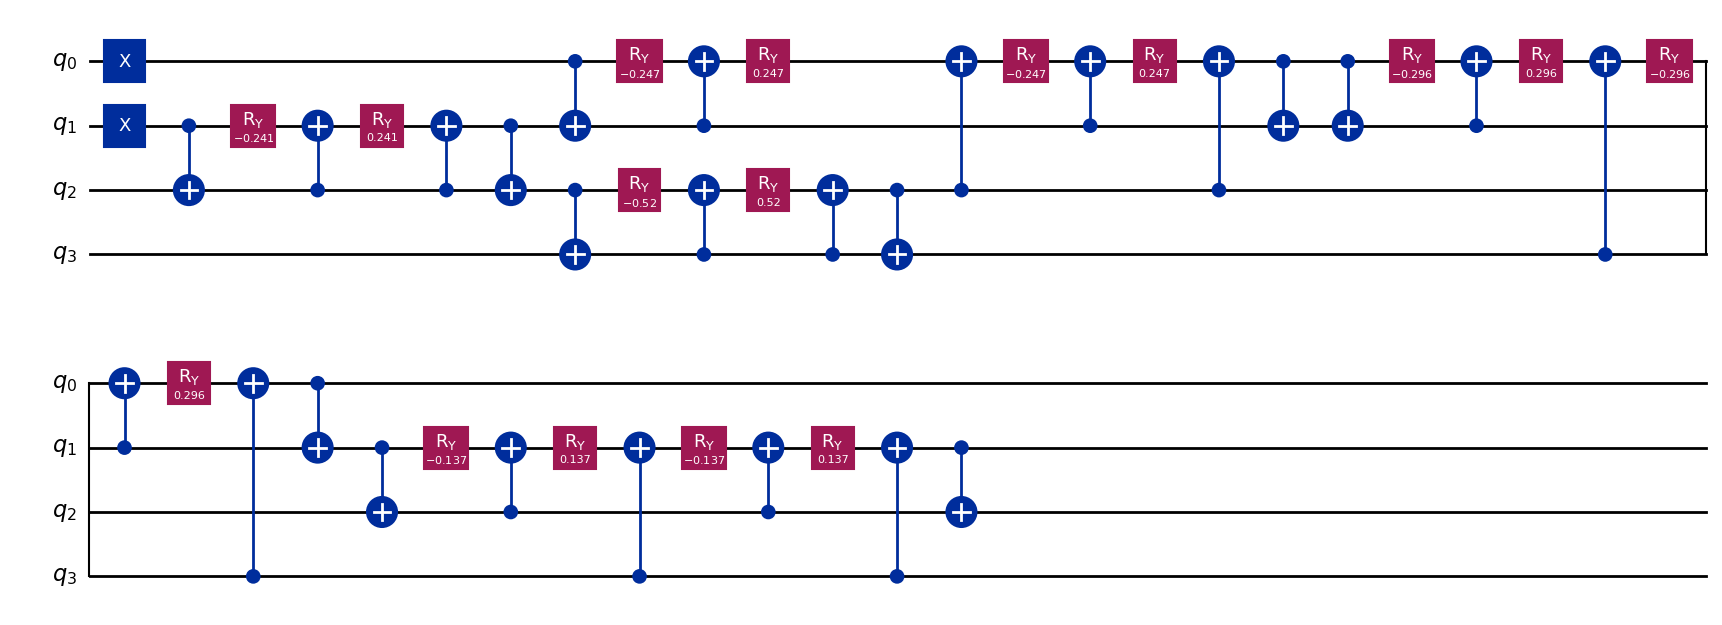

In [2]:
def ansatz(params, method="FCI"):
    qc = QuantumCircuit(Norb)
    # HF
    qc.x(0)
    qc.x(1)
    ## FCI
    if method == "FCI":
        G(qc, 1, 2, params[0])
        G(qc, 2, 3, params[1])
        cG1(qc, 2, 0, 1, params[2])
        cG1(qc, 3, 0, 1, params[3])
        cG1(qc, 3, 1, 2, params[4])
    return qc

params = np.random.rand(5) * np.pi 
params = params_exact

qc = ansatz(params)
qc.draw(output='mpl')

次に、用意した回路から、各状態のstatevectorを計算してみよう。

なお、statevectorのときはmeasurementをいれていると、確定した一つの状態になってしまう。
回路を作り直すか、`qc.remove_final_measurements()`などを実行しよう。

In [3]:
from qiskit.quantum_info import Statevector

state_vector = Statevector.from_instruction(qc)
state_vector

Statevector([5.55111512e-17+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
             9.71213909e-01+0.j, 0.00000000e+00+0.j, 1.81939134e-01+0.j,
             9.81735082e-02+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
             9.81721942e-02+0.j, 6.36069907e-02+0.j, 0.00000000e+00+0.j,
             1.78892924e-02+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
             0.00000000e+00+0.j],
            dims=(2, 2, 2, 2))


In [4]:
state_vector.draw("latex")

<IPython.core.display.Latex object>

In [5]:
print(evecs[:,0])

[0.97121327 0.18194077 0.09817385 0.09817385 0.06360816 0.01789242]


厳密解を再現できた。

## ハミルトニアンの表現


Qiskitの場合、ビット列とqubitの対応のさせかたが逆順(というと語弊があるが)なことに注意が必要。

演算子のpauli stringが`IXII`のとき、`X`が作用するのは、0から数えて1番目のqubit...としたいところだが、
Qiskitでは、回路(qubit)の上(indexが若い方)から下をビット列の下位ビットから割り当てるので、`X`が作用するのは2番目のqubitになる。

In [6]:
from qiskit.quantum_info import SparsePauliOp

SPEs = Hamil.epsilon

#observable = SparsePauliOp.from_list([("ZIII", 1.0), ("IIIZ", 1.0), ("IIZZ", 1.0)])
# Hamiltonianを使う場合
pauli_list = [ ]
obs = [ ]
coeffs = [ ]

# I term
coeff = 0.0
op = "I" * Norb
for i in range(Norb):
    coeff += 0.5 * ( SPEs[i] - Hamil.gval ) 
obs += [op]
coeffs += [coeff]
# -Zp term
for i in range(Norb):
    op = "I" * Norb
    op = op[:i] + "Z" + op[i+1:]
    coeff = -0.5 * ( SPEs[i] - Hamil.gval )

    op = op[::-1]
    obs += [op]
    coeffs += [coeff]
# XX+YY term
for i in range(Hamil.Norb):
    for j in range(i+1, Hamil.Norb):
        factor = - Hamil.gval / 2
        op = "I" * Norb
        op = op[:i] + "X" + op[i+1:j] + "X" + op[j+1:]
        op = op[::-1]
        obs += [op]
        coeffs += [ factor ]
        op = "I" * Norb
        op = op[::-1]
        op = op[:i] + "Y" + op[i+1:j] + "Y" + op[j+1:]
        obs += [op]
        coeffs += [ factor ]

hamiltonian_op = SparsePauliOp(obs, coeffs)
hamiltonian_op

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIXX', 'YYII', 'IXIX', 'YIYI', 'XIIX', 'YIIY', 'IXXI', 'IYYI', 'XIXI', 'IYIY', 'XXII', 'IIYY'],
              coeffs=[ 5.34 +0.j,  0.165+0.j, -0.835+0.j, -1.835+0.j, -2.835+0.j, -0.165+0.j,
 -0.165+0.j, -0.165+0.j, -0.165+0.j, -0.165+0.j, -0.165+0.j, -0.165+0.j,
 -0.165+0.j, -0.165+0.j, -0.165+0.j, -0.165+0.j, -0.165+0.j])

## 回路によるハミルトニアンの期待値の測定



In [7]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
job = estimator.run([(qc, hamiltonian_op,)])
results = job.result()
E_meas = results[0].data.evs
print("E_meas: ", E_meas, "Egs_exact: ", Egs_exact, "diff.", E_meas - Egs_exact)

E_meas:  1.1898518352304355 Egs_exact:  1.1898518351360725 diff. 9.436296188880533e-11


厳密解を再現できた。上ではtranspileしなかったが、実機に応じたマッピングをしたい場合、
noisy simulatorを試したい場合などはtranspileが必要になる。

ノイズなしの場合のshot 測定

Counts(ideal): {'0011': 9457, '0101': 310, '1001': 99, '1010': 37, '0110': 97}


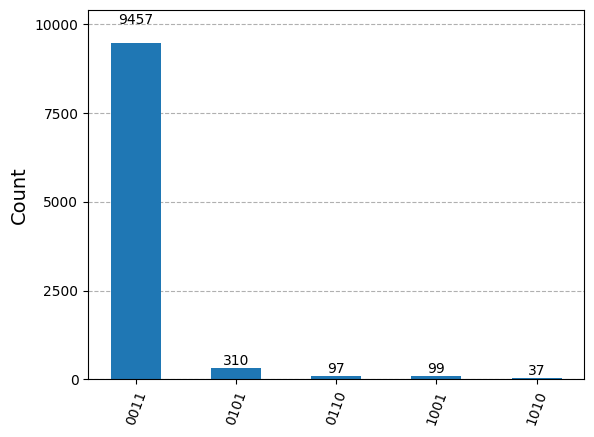

In [8]:
from qiskit_aer.primitives import SamplerV2
sampler = SamplerV2()

qc = ansatz(params)
qc.measure_all()
tqc = transpile(qc)

# Construct an ideal simulator with SamplerV2
sampler = SamplerV2()
job = sampler.run([qc], shots=10000)

result_ftqc = job.result()
counts_ftqc = result_ftqc[0].data.meas.get_counts()
print('Counts(ideal):', counts_ftqc)

plot_histogram(counts_ftqc)

ノイズありの場合

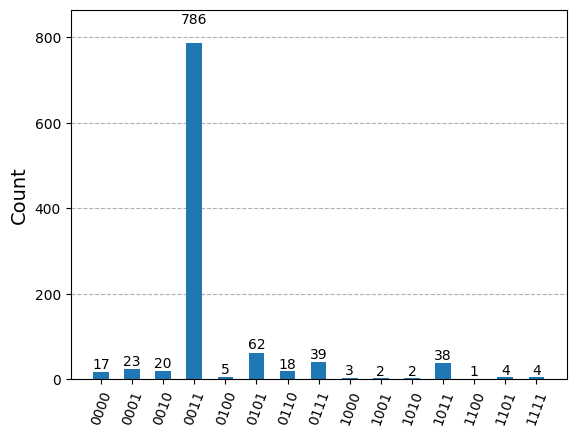

In [9]:
from qiskit_ibm_runtime.fake_provider import FakeQuebec
from qiskit_aer import AerSimulator

device_backend = FakeQuebec()
sim_quebec = AerSimulator.from_backend(device_backend)

qc = ansatz(params)
qc.measure_all()
tqc = transpile(qc, sim_quebec)

result_noise = sim_quebec.run(tqc, shot=10**4).result()
counts_noise = result_noise.get_counts(0)
plot_histogram(counts_noise)

In [10]:
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Estimator as AerEstimator

device = FakeManilaV2()
coupling_map = device.coupling_map
noise_model = NoiseModel.from_backend(device)

noisy_estimator = AerEstimator(
    backend_options={
        'method': 'density_matrix',
        'coupling_map': coupling_map,
        'noise_model': noise_model,
    },
    run_options={'shots': 1024}
)

qc = ansatz(params_exact)
qc.remove_final_measurements()
noisy_expval = noisy_estimator.run([qc], [hamiltonian_op]).result().values[0]
print(f'{noisy_expval=}')


noisy_expval=1.8307519531250003


## 制御ユニタリ演算子の作成

controlled-U演算子を作成する。Qiskitには`PauliEvolutionGate`があり、これにより$U=e^{-i\hat{H}t}$などを実装できる。
マイナス符号がdefaultなので、位相推定による期待値計算などの際にはそのことを考慮する。

あとは言うまでもなく、一般の演算子をexponentiateする際は、Trotter分解のところでerrorが生じる。

In [11]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

time = 1.e-1
trotter_steps = 30
op = PauliEvolutionGate(hamiltonian_op, time, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
U = op.definition

## Hadamard test

Hadamard testを実装する。

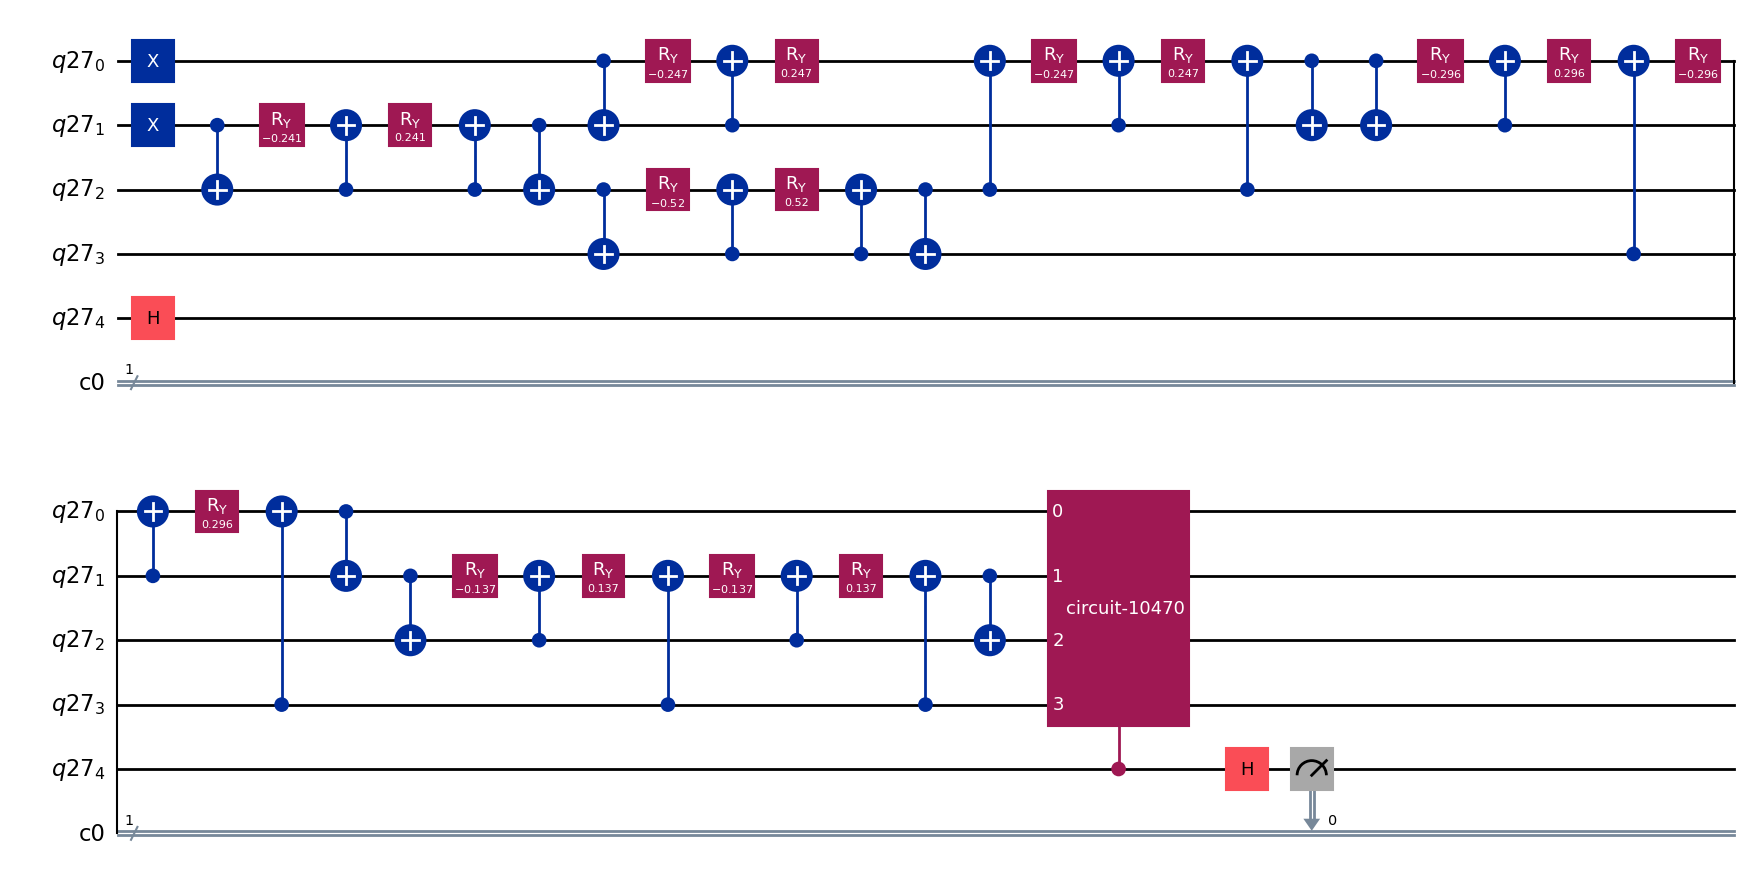

In [12]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

qr_Hadamard = QuantumRegister(Norb+1)
cr_Hadamard = ClassicalRegister(1)
qc_Hadamard = QuantumCircuit(qr_Hadamard, cr_Hadamard)

# State preparation
params = params_exact
psi = ansatz(params)
qc_Hadamard.x(0)
qc_Hadamard.x(1)
G(qc_Hadamard, 1, 2, params[0])
G(qc_Hadamard, 2, 3, params[1])
cG1(qc_Hadamard, 2, 0, 1, params[2])
cG1(qc_Hadamard, 3, 0, 1, params[3])
cG1(qc_Hadamard, 3, 1, 2, params[4])

# Hadamard on ancilla
qc_Hadamard.h(4)
# controlled-U
cU = U.to_gate().control(1)
qc_Hadamard.append(cU, [4, 0, 1, 2, 3])
# Hadamard on ancilla and measurement
qc_Hadamard.h(4)

# for measurement
qc_1 = qc_Hadamard.copy()
qc_1.measure(4, 0)

# for statevector
qc_2 = qc_Hadamard.copy()

# Draw the circuit
qc_1.draw(output='mpl')

測ってみよう

In [13]:
qc_1 = qc_1.decompose()

n_shot = 10**4
sim = AerSimulator()
counts = sim.run(qc_1, shots=n_shot).result().get_counts()
counts

p0 = counts.get('0', 0) / n_shot
p1 = counts.get('1', 0) / n_shot
print(f'p0={p0}, p1={p1}')

p0=0.9959, p1=0.0041


$$
\begin{align}
P(0) & =  \left| \frac{1 + e^{iEt}}{2} \right|^2 = \frac{1 + \cos(Et)}{2} \\
P(1) & =  \left| \frac{1 - e^{iEt}}{2} \right|^2 = \frac{1 - \cos(Et)}{2} \\
\end{align}
$$

なので、

In [14]:
Et = p0 - p1
E = np.arccos(Et) / time
print("E:", E, "Egs_exact: ", Egs_exact, "diff.", E - Egs_exact)

E: 1.2815015596314208 Egs_exact:  1.1898518351360725 diff. 0.09164972449534825


Statevectorの場合は...$t$などを変えない限りは実行ごとに同じ結果になる。

In [15]:
qc2 = qc_2.decompose()

state_vector = Statevector.from_instruction(qc2)
sv_arr = np.array(state_vector)

p0 = p1 = 0
for k in range(2**(1+Norb)):
    ancilla = k >> Norb
    if ancilla == 0:
        p0 += sv_arr[k] * np.conj(sv_arr[k])
    else:
        p1 += sv_arr[k] * np.conj(sv_arr[k])
    #print("bitstring:", format(k, f'0{Norb+1}b'),  "ancilla", type(ancilla), "statevector:", np.real(sv_arr[k]))
print("p0:", p0, "p1:", p1)
Et = p0 - p1
E = np.real( np.arccos(Et) / time )
print("E:", np.real(E), "Egs_exact: ", Egs_exact, "diff.", E - Egs_exact)

p0: (0.9964647046884759-6.504273346999322e-20j) p1: (0.003535295311496305-3.661736703614765e-21j)
E: 1.1898687808110961 Egs_exact:  1.1898518351360725 diff. 1.694567502363853e-05


## 量子位相推定(QPE)

続いて、量子位相推定(QPE)を実装する。

In [16]:
from qiskit.circuit.library import phase_estimation

### 簡単な例

いきなりHamiltonianの期待値を求めようとすると間違えたりするのでまずは簡単な例から。

ターゲット量子ビットは1~2個にして、比較的簡単な状態作成&制御ユニタリ演算子を作成しよう。


**例1: $U=CP(\phi)$で1ターゲット量子ビットをP-gateの固有状態にとる場合**


$P(\phi) = \ket{0}\bra{0} + e^{i\phi}\ket{1}\bra{1}$なので、
$\ket{\psi} = \ket{1}$を用意すれば、推定したい位相は$\phi/2\pi$になる。

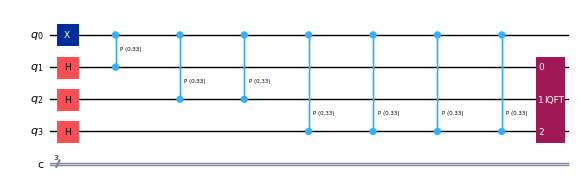

In [17]:
from qiskit.circuit.library.standard_gates import PhaseGate
from qiskit.circuit.library import QFT

def circuit_ex1(n_ancilla, theta, measure=True, using_qiskit=True):
    qc = QuantumCircuit(n_ancilla + 1, n_ancilla)
    register_ancilla = range(1, 1+n_ancilla)
    register_target = range(1)
    # State preparation
    qc.x(register_target) # |1>

    # Hadamard on ancilla
    for qubit in register_ancilla:
        qc.h(qubit)
    # Controlled-U operations
    repetitions = 1
    for counting_qubit in register_ancilla:
        for _ in range(repetitions):
            qc.cp(theta, counting_qubit, 0)
        repetitions *= 2
    
    # Inverse QFT
    qft_dagger = QFT(n_ancilla, inverse=True)   
    qc.append(qft_dagger, register_ancilla)

    if measure:
        qc.measure(register_ancilla, range(n_ancilla))
    return qc

n_ancilla = 3
theta = 0.33 
qc_QPE = circuit_ex1(n_ancilla, theta, measure=False, using_qiskit=True)
qc_QPE.draw(output='mpl', scale=0.5)

In [18]:
n_ancilla = 10
theta = np.pi / 8

qc_QPE = circuit_ex1(n_ancilla, theta, measure=False, using_qiskit=True)
qc_QPE = qc_QPE.decompose()#.decompose()
state_vector = Statevector.from_instruction(qc_QPE)

idxs = np.argsort(np.abs(state_vector.data))[::-1][:5]
print("top5: ", idxs)
for idx in idxs:
    bitstr_from_idx = format(idx, f'0{n_ancilla+1}b')
    bit_ancilla = bitstr_from_idx[:n_ancilla]
    estimated = int(bit_ancilla, 2)/(2**n_ancilla) * 2 * np.pi
    print("idx", idx, "estimated_theta", estimated)
print("theta_exact", theta, "err 2pi/2^n", 2*np.pi/2**n_ancilla)

top5:  [129 137 121 125 133]
idx 129 estimated_theta 0.39269908169872414
idx 137 estimated_theta 0.4172427743048944
idx 121 estimated_theta 0.36815538909255385
idx 125 estimated_theta 0.380427235395639
idx 133 estimated_theta 0.4049709280018093
theta_exact 0.39269908169872414 err 2pi/2^n 0.006135923151542565


推定したい位相が(たまたま)$2\pi/2^m$のときは,$m$個のancillaを用意すれば、理想的には位相を厳密に推定できる。
それ以外の場合は$2\pi/2^n$の精度で推定することになる。
さらには実際にノイズの影響もあり古典計算機で行うような倍精度で推定することは困難である。

In [19]:
# shot measurement
qc_QPE = circuit_ex1(n_ancilla, theta, measure=True, using_qiskit=True)
qc_QPE = qc_QPE.decompose().decompose().decompose()

n_shot = 1024
sim = AerSimulator()
counts = sim.run(qc_QPE, shots=n_shot).result().get_counts()

bitstrs = [ ]
x = []
y = []
for k, v in counts.items():
    bitstrs += [k]
    x += [int(k, 2)/(2**n_ancilla) ]
    y += [v]
idx = np.argmax(y)
theta_estimated = x[idx]*2*np.pi
print("idx", idx, "bitstr", bitstrs[idx], "theta", theta_estimated, "theta_exact", theta, "diff", theta_estimated - theta)

idx 0 bitstr 0001000000 theta 0.39269908169872414 theta_exact 0.39269908169872414 diff 0.0


**例2: 数演算子の時間発展を考える。**

$\ket{\psi} = \ket{11} $

$U = \exp{(i t (I_0-Z_0) \otimes (I_1-Z_1))}$

$ (I_0-Z_0) \otimes (I_1-Z_1) \ket{\psi} = 4 \ket{11}$なので、
$ \exp{(i t (I_0-Z_0) \otimes (I_1-Z_1))} \ket{\psi} = \exp{(i 4 t)} \ket{11}$となり、$\ket{\psi}$は$U$の固有状態、固有値は$e^{i4t}$である。

したがって、位相推定で得た$\theta$から$2\pi \theta / t$を計算して、$4$を得ることができれば成功である。

In [20]:
time = 0.1234
trotter_steps = 50
obs = [ "II", "ZI", "IZ", "ZZ"]
coeffs = [ -1.0, 1.0, 1.0, -1.0]
org_op = SparsePauliOp(obs, coeffs)
unitary = PauliEvolutionGate(org_op, time, label="U", synthesis=SuzukiTrotter(order=1, reps=trotter_steps))

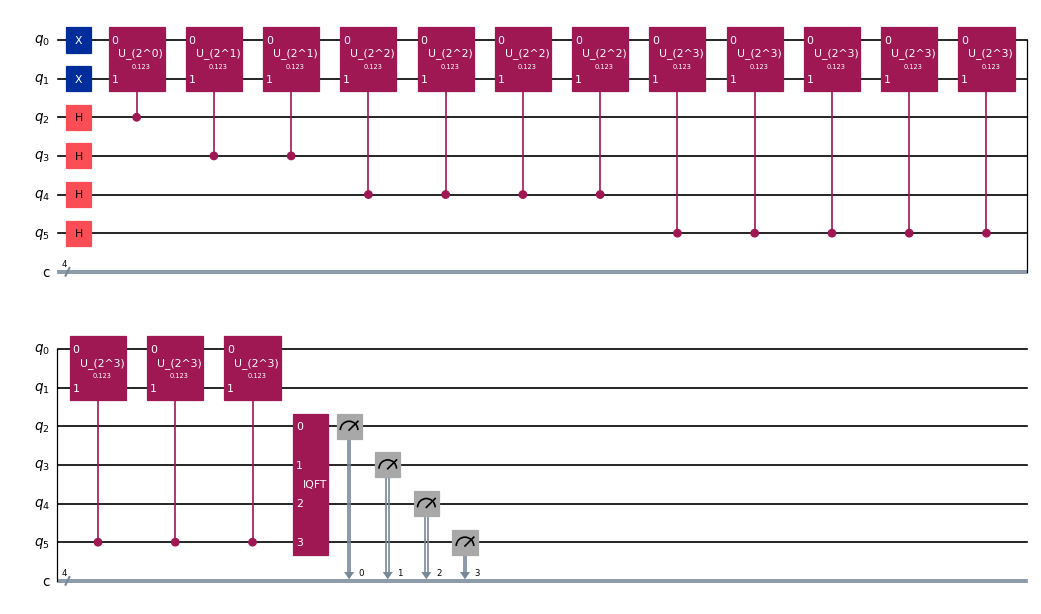

In [21]:
def make_QPE_circuit_ex2(n_ancilla, n_psi, unitary, measure=True):
    qc_QPE = QuantumCircuit(n_ancilla + n_psi, n_ancilla)
    register_ancilla = range(n_psi, n_psi+n_ancilla)
    register_target = range(n_psi)

    # State preparation
    qc_QPE.x(0)
    qc_QPE.x(1)

    # Hadamard on ancilla
    for qubit in register_ancilla:
        qc_QPE.h(qubit)
    # Controlled-U operations
    repetitions = 1
    for counting_qubit in register_ancilla:
        for _ in range(repetitions):
            unitary.label = f"U_(2^{int(np.log2(repetitions))})"
            unitary_ctrl = unitary.control(1)
            qc_QPE.append(unitary_ctrl, [counting_qubit] + list(register_target))            
        repetitions *= 2
    # Inverse QFT
    qft_dagger = QFT(n_ancilla, inverse=True)   
    qc_QPE.append(qft_dagger, register_ancilla)
    
    if measure:
        qc_QPE.measure(register_ancilla, range(n_ancilla))
    return qc_QPE

n_ancilla = 4
n_psi = 2
qc_QPE = make_QPE_circuit_ex2(n_ancilla, n_psi, unitary)
qc_QPE.draw(output='mpl', scale=0.6)

In [22]:
# Statevector
n_ancilla = 8
n_psi = 2

qc_QPE = make_QPE_circuit_ex2(n_ancilla, n_psi, unitary, measure=False)
qc_QPE = qc_QPE.decompose()#.decompose()
state_vector = Statevector.from_instruction(qc_QPE)

In [23]:
idxs = np.argsort(np.abs(state_vector.data))[::-1][:5]
print("top5: ", idxs)
for idx in idxs:
    bitstr_from_idx = format(idx, f'0{n_ancilla+n_psi}b')
    bit_ancilla = bitstr_from_idx[:n_ancilla]
    theta= int(bit_ancilla, 2)/(2**n_ancilla) 
    lambda_t = theta * 2 * np.pi / time 
    print("idx", idx, "theta", theta, "lambda=2pitheta/time", lambda_t)

top5:  [83 87 79 91 75]
idx 83 theta 0.078125 lambda=2pitheta/time 3.977908039897935
idx 87 theta 0.08203125 lambda=2pitheta/time 4.176803441892832
idx 79 theta 0.07421875 lambda=2pitheta/time 3.779012637903038
idx 91 theta 0.0859375 lambda=2pitheta/time 4.3756988438877285
idx 75 theta 0.0703125 lambda=2pitheta/time 3.5801172359081415


### pairing hamiltonian

次に、pairing Hamiltonianの場合を考える

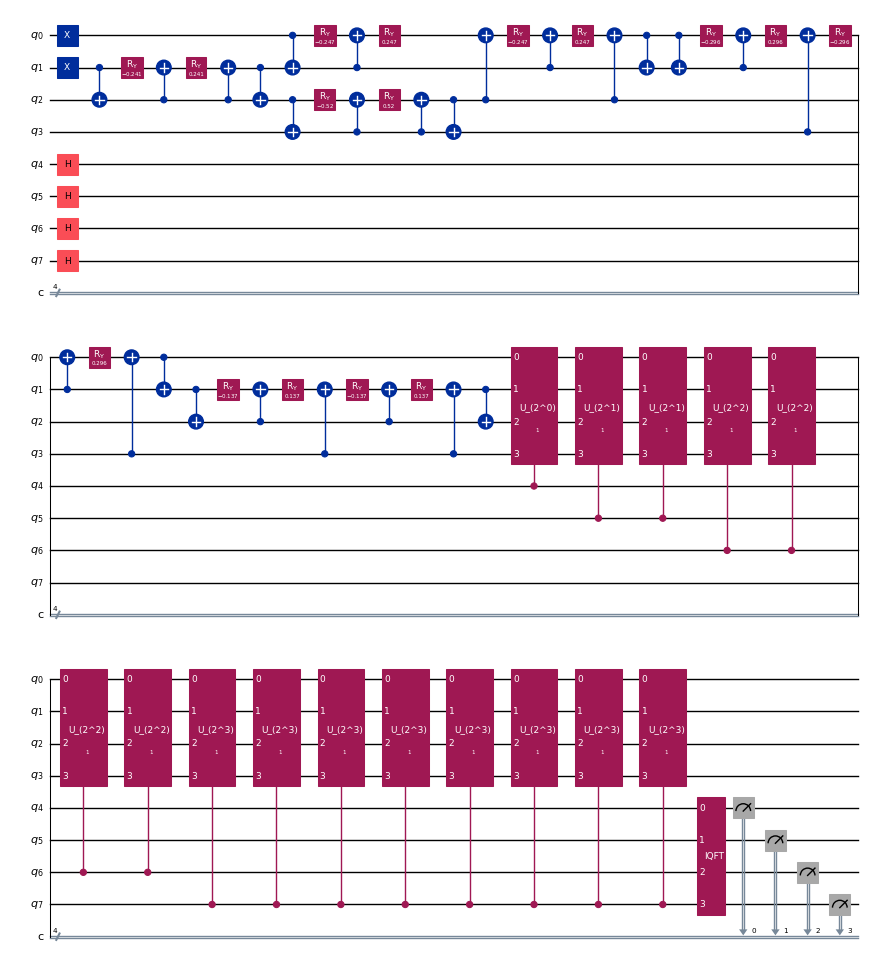

In [24]:
from qiskit.circuit.library import QFT
from qiskit.circuit.library import PhaseEstimation # will be deprecated
from qiskit.circuit.library import phase_estimation

def state_preparation(qc, params, method="FCI"):
    if Norb != 4:
        raise ValueError("This function is only for Norb=4")
    # HF
    qc.x(0)
    qc.x(1)
    ## FCI
    if method == "FCI":
        G(qc, 1, 2, params[0])
        G(qc, 2, 3, params[1])
        cG1(qc, 2, 0, 1, params[2])
        cG1(qc, 3, 0, 1, params[3])
        cG1(qc, 3, 1, 2, params[4])
    return qc

def make_QPE_circuit(n_ancilla, Norb, params_psi, measure=False):
    qc_QPE = QuantumCircuit(n_ancilla + Norb, n_ancilla)
    register_ancilla = range(Norb, Norb+n_ancilla)
    register_target = range(Norb)
    # State preparation
    state_preparation(qc_QPE, params_psi)

    # Hadamard on ancilla
    for qubit in register_ancilla:
        qc_QPE.h(qubit)
    # Controlled-U operations
    U = PauliEvolutionGate(hamiltonian_op, time, synthesis=SuzukiTrotter(order=1,reps=trotter_steps))
    repetitions = 1
    for counting_qubit in register_ancilla:
        for _ in range(repetitions):
            U.label = f"U_(2^{int(np.log2(repetitions))})"
            U_ctrl = U.control(1)
            qc_QPE.append(U_ctrl, [counting_qubit] + list(register_target))            
        repetitions *= 2
    # Inverse QFT
    qft_dagger = QFT(n_ancilla, inverse=True)
    qc_QPE.append(qft_dagger, register_ancilla)

    if measure:
        qc_QPE.measure(register_ancilla, range(n_ancilla))
    return qc_QPE

n_ancilla = 4 
params_psi = params_exact
time = 1.0

qc_QPE = make_QPE_circuit(n_ancilla, Norb, params_psi, measure=True)
qc_QPE.draw(output='mpl', scale=0.5)

In [25]:
params_psi = params_exact
n_ancilla = 10
time = - 1.e-1
trotter_steps = 20

In [26]:
# shot measurement
qc_QPE = make_QPE_circuit(n_ancilla, Norb, params_psi, measure=True)
qc_QPE = qc_QPE.decompose().decompose()

n_shot = 1024
sim = AerSimulator()
counts = sim.run(qc_QPE, shots=n_shot).result().get_counts()

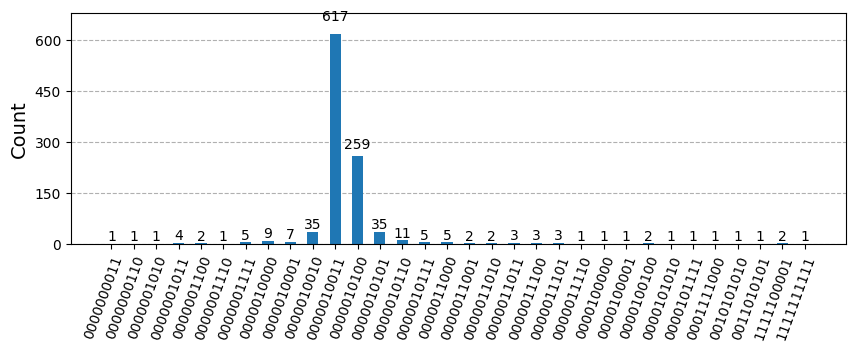

In [27]:
plot_histogram(counts,figsize=(10, 3))

In [28]:
float_from_bitstr = lambda bitstr: int(bitstr, 2)/(2**n_ancilla) * 2 * np.pi / -time
 
E_estimated = float_from_bitstr(counts.most_frequent())
print(f"E_estimated: {E_estimated:.8f} Egs_exact: {Egs_exact:.8f} diff. {E_estimated - Egs_exact:.2e}")

E_estimated: 1.16582540 Egs_exact: 1.18985184 diff. -2.40e-02
